## Import Required Libraries

In [1]:
# For General Plotting
import matplotlib.pyplot as plt
import matplotlib.cm
%matplotlib inline

# For Map Plotting
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize, rgb2hex, rgb_to_hsv
import matplotlib.cm as cm

# For Data Processing & Cleaning
import numpy as np
import pandas as pd
import re

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
# Global variables
STANDARD_SIZE = 80
TOP_SIZE = 500
TOP_LIMIT = 10

In [3]:
# Load stations w/ coordinates (from )
df_stations = pd.read_csv('DOITT_SUBWAY_STATION_01_13SEPT2010.csv', header=0)
df_stations = df_stations[['NAME', 'the_geom']]
df_stations = df_stations.drop_duplicates(subset=['NAME'])
df_stations.head()

,NAME,the_geom
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978)
1,Canal St,POINT (-74.00019299927328 40.71880300107709)
2,50th St,POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568)


In [4]:
# Helper functions for parsing longitude and latitude from raw imported data
def parse_geom_data(geom_str):
    geom_str = geom_str.replace('POINT (','')
    geom_str = geom_str.replace(')','')
    return [float(i) for i in geom_str.split(' ')]

def get_lon(geom_str):
    return parse_geom_data(geom_str)[0]

def get_lat(geom_str):
    return parse_geom_data(geom_str)[1]

In [5]:
# Clean station geo-location data
df_stations['Lon'] = df_stations['the_geom'].apply(get_lon)
df_stations['Lat'] = df_stations['the_geom'].apply(get_lat)
geo_stations = pd.unique(df_stations['NAME'])
df_stations.head()

,NAME,the_geom,Lon,Lat
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978),-73.991070,40.730054
1,Canal St,POINT (-74.00019299927328 40.71880300107709),-74.000193,40.718803
2,50th St,POINT (-73.98384899986625 40.76172799961419),-73.983849,40.761728
3,Bergen St,POINT (-73.97499915116808 40.68086213682956),-73.974999,40.680862
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),-73.894886,40.664714


In [6]:
# Cleaning station names to match location data to MTA turnstile data

suffix_re = re.compile(r'[0-9][a-z]+[^a-zA-Z0-9]', re.IGNORECASE)
mapping_street_name = {'ave': 'avenue',
                       'av': 'avenue',
                       'st': 'street',
                       'dr': 'drive',
                       'pky': 'parkway',
                       'pkwy': 'parkway',
                       'sq': 'square',
                       'w': 'west',
                       'stn': 'station',
                       'ctr': 'center',
                       'blvd': 'boulevard',
                       'e': 'east',
                       'wash': 'washington',
                       'sts': 'stations',
                       'hts': 'heights',
                       'pl': 'place',
                       'conc': 'concourse',
                       'qnsbridge': 'queensbridge',
                       'yd': 'yard',
                       'yrd': 'yard',
                       'sta': 'station',
                       'university': '',
                       'plaza': '',
                       'plaz': '',
                       'col': 'college',
                       'park': '',
                       'stad': 'stadium',
                       'amsterdm': 'amsterdam',
                       'pk': 'park',
                       'auth': 'authority',
                       'ln': 'lane',
                       'n.cond': 'north conduit avenue',
                       'racetr': 'racetrack',
                       'atl': 'atlantic',
                       'nostran': 'nostrand',
                       'aves': '',
                       'jct': 'junction',
                       'aberdeen': 'avenue'}
street_name_re = re.compile(r'\s+', re.IGNORECASE)

changes_street_name = {}

def update_street_name(name):
    ignore_symbols = ['-', '/', '(', ')']
    for sym in ignore_symbols:
        name = name.replace(sym, ' ')
    
    # Remove multiple spaces
    name = re.sub(r'\s+', ' ', name)
    
    ignore_suffixes = ['st', 'rd', 'th', 'nd']
    m = suffix_re.search(name)
    i = 1
    while m and i<4:
        if (m.group()[1:-1] in ignore_suffixes):
            name = name[:m.start()+1] + name[m.end()-1:]
        m = suffix_re.search(name)
        i+=1
            
    name_split = street_name_re.split(name)
    for i in range(len(name_split)):
        if name_split[i].lower() in mapping_street_name.keys():
            name_split[i] = mapping_street_name[name_split[i].lower()]
    name = ' '.join(name_split)
#     print(m.group())
#     if m:
#         street_type = m.group()
#         if street_type in mapping_street_name.keys():
#             name = name[:m.start()] + mapping_street_name[street_type.lower()] + name[m.end():]
    name = name.upper().strip()
    
    # manual
    name = name.replace('138 GRAND CONCOURSE', '138 STREET GRAND CONCOURSE')
    name = name.replace('149 GRAND CONCOURSE', '149 STREET GRAND CONCOURSE')
    name = name.replace('161 STREET YANKEE STADIUM', '161 YANKEE STADIUM')
    name = name.replace('163 STREET AMSTERDAM AVENUE', '163 STREET AMSTERDAM')
    name = name.replace('34 STREET HUDSON YARDS', '34 STREET HUDSON YARD')
    name = name.replace(' LOWERY STREET', '')
    name = name.replace(' BUS TERM', '')
    name = name.replace('ROCKEFELLER CENTER', 'ROCK')
    name = name.replace('COLUMBUS CIRCLE', 'COLUMBUS')
    name = name.replace('5 AVENUE BRYANT PARK', '5 AVENUE')
    name = name.replace('LINCOLN CENTER', 'LINCOLN')
    name = name.replace('68ST HUNTER CO', '68 STREET HUNTER COLLEGE')
    name = name.replace('75 STREET ELDERT LANE', '75 STREET ELDERTS')
    name = name.replace('81 STREET MUSEUM', '81 STREET')
    name = name.replace('82 STREET JACKSON HEIGHTS', '82 STREET JACKSON H')
    name = name.replace('85 STREET FOREST PARKWAY', '85 STREET FOREST PARK')
    name = name.replace('90 STREET ELMHURST AVENUE', '90 STREET ELMHURST')
    name = name.replace("BARCLAY'S CENTER", 'BARCLAY')
    name = name.replace('ASTORIA DITMARS BOULEVARD', 'ASTORIA DITMARS')
    name = name.replace('BRIARWOOD VAN WYCK BOULEVARD', 'BRIARWOOD')
    name = name.replace(' LAFAYETTE STREET', '')
    name = name.replace('BROOKLYN BRIDGE CITY HALL', 'BROOKLYN BRIDGE')
    name = name.replace('FLATBUSH AVENUE B.C', 'BROOKLYN COLLEGE FLATBUSH AVENUE')
    name = name.replace(' HOLLAND TUNNEL', '')
    name = name.replace('ROCKAW', 'ROCKAWAY PARKWAY')
    name = name.replace('CROWN HEIGHTS UTICA AVENUE', 'CROWN HEIGHTS UTICA')
    name = name.replace(' PARKWAYAY', '')
    name = name.replace('CENTRAL PARK N110', 'CENTRAL  NORTH 110 STREET')
    name = name.replace('CATHEDRAL PARKWAY 110 STREET', 'CATHEDRAL PARKWAY')
    name = name.replace('CHRISTOPHER STREET SHERIDAN SQUARE', 'CHRISTOPHER STREET')
    name = name.replace('CLINTON WASHINGTON AVENUE', 'CLINTON WASHINGTON')
    name = name.replace('FLUSHING MAIN STREET', 'FLUSHING MAIN')
    name = name.replace('GRAND CENTRAL 42 STREET', 'GRD CNTRL 42 STREET')
    name = name.replace('HERALD SQUARE 34 STREET', '34 STREET HERALD SQUARE')
    name = name.replace('LEXINGTON AVENUE 53 STREET', 'LEXINGTON AVENUE 53')
    name = name.replace('LEXINGTON AVENUE 63 STREET', 'LEXINGTON AVENUE 63')
    name = name.replace('METS WILLETS POINT', 'METS WILLETS PT')
    name = name.replace('UNION SQUARE 14 STREET', '14 STREET UNION SQUARE')
    name = name.replace('CONEY ISLAND STILLWELL AVENUE', 'CONEY IS STILLW')
    name = name.replace('DELANCEY STREET ESSEX STREET', 'DELANCEY ESSEX')
    name = name.replace("EAST 143 STREET STREET MARY'S STREET", "EAST 143 STREET MARY'S")
    name = name.replace('EASTCHESTER DYRE AVENUE', 'EASTCHESTER DYRE')
    name = name.replace('EASTN PARKWAY MUSM', 'EASTERN PARKWAY BKLYN MUSEUM')
    name = name.replace('EASTCHSTER', 'EASTCHESTER')
    name = name.replace(' MOTT AVENUE', '')
    name = name.replace('FOREST HILLS 71 AVENUE', 'FOREST HILLS 71')
    name = name.replace('FRANKLIN AVENUE FULTON STREET', 'FRANKLIN AVENUE')
    name = name.replace('GRAND NEWTOWN', 'GRAND AVENUE NEWTOWN')
    name = name.replace('PATH NEW WTC', 'WORLD TRADE CENTER')
    
    return name

In [2]:
# Testing location and MTA dataframes station re-naming
# Set to True to run check
if False:
    u_geo = []
    for i in sorted(geo_stations):
        u_geo.append(update_street_name(i))
        print("%s -> %s" % (i, u_geo[-1]))

    df_mta = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt', header=0)
    mta_stations = pd.unique(df_mta['STATION'])
    # sorted([i.lower() for i in mta_stations])

    u_mta = []
    for i in sorted(mta_stations):
        u_mta.append(update_street_name(i))
        print("%s -> %s" % (i, u_mta[-1]))
    #     print(i)

In [8]:
# Attempt to match Geo-location station names to MTA turnstile stations
# Set to True to run check
if False:
    i = 1
    for u in u_geo:
        found = False
        for v in u_mta:
            if u == v:
                found = True
                i += 1
                print('(%d) %s : %s' % (i, u, v))
                break
        if not found:
            print('%s : []' % u)

## Plot Data on Map

In [9]:
## Import IRS income data
df_income = pd.read_csv('zips_and_scores.csv', index_col=0).loc[:,'average']
df_income.head()

zipcode
10001    3.241789
10002    2.112063
10003    3.705158
10004    4.180723
10005    4.025974
Name: average, dtype: float64

In [10]:
# Adjust names for geo-location data
df_stations['Name_Adj'] = df_stations['NAME'].apply(update_street_name)
df_stations.head()

,NAME,the_geom,Lon,Lat,Name_Adj
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978),-73.991070,40.730054,ASTOR PLACE
1,Canal St,POINT (-74.00019299927328 40.71880300107709),-74.000193,40.718803,CANAL STREET
2,50th St,POINT (-73.98384899986625 40.76172799961419),-73.983849,40.761728,50 STREET
3,Bergen St,POINT (-73.97499915116808 40.68086213682956),-73.974999,40.680862,BERGEN STREET
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),-73.894886,40.664714,PENNSYLVANIA AVENUE


In [11]:
# Load and adjust names for MTA turnstile data
df_mta = pd.read_csv('mta_data_for_map.csv', header=None)
df_mta.columns = ['NAME', 'Traffic']
df_mta['Name_Adj'] = df_mta['NAME'].apply(update_street_name)
df_mta.head(20)

,NAME,Traffic,Name_Adj
0,34 ST-PENN STA,997021,34 STREET PENN STATION
1,GRD CNTRL-42 ST,873997,GRD CNTRL 42 STREET
2,34 ST-HERALD SQ,773600,34 STREET HERALD SQUARE
3,23 ST,761990,23 STREET
4,14 ST-UNION SQ,672204,14 STREET UNION SQUARE
5,42 ST-PORT AUTH,630240,42 STREET PORT AUTHORITY
6,TIMES SQ-42 ST,620585,TIMES SQUARE 42 STREET
7,PATH NEW WTC,597435,WORLD TRADE CENTER
8,FULTON ST,564479,FULTON STREET
9,86 ST,557455,86 STREET


In [12]:
df_mta['Traffic'].max()

997021

In [13]:
def get_size(x):
    top_10_list = ['34 STREET PENN STATION',
                   'GRD CNTRL 42 STREET',
                   '34 STREET HERALD SQUARE',
                   '14 STREET UNION SQUARE',
                   '42 STREET PORT AUTHORITY',
                   'TIMES SQUARE 42 STREET',
                   'WORLD TRADE CENTER',
                   'FULTON STREET',
                   '59 STREET COLUMBUS',
                   'FLUSHING MAIN']
    if x in top_10_list:
        return TOP_SIZE
    return STANDARD_SIZE

In [14]:
## Join Data!!
df_comb = df_mta[['Name_Adj', 'Traffic']].merge(df_stations[['Name_Adj', 'Lon', 'Lat']], how='inner', on='Name_Adj', )
df_comb = df_comb.sort_values(by='Traffic', ascending=False)
top = TOP_LIMIT
top_size = TOP_SIZE
standard_size = STANDARD_SIZE
df_comb['Size'] = df_comb['Name_Adj'].apply(get_size)
# df_comb['Size'] = [top_size]*top + [standard_size]*(len(df_comb)-top)
df_comb.iloc[3,1] = 761990/3
df_comb.drop_duplicates(subset='Name_Adj', keep='first', inplace=True)
df_comb.head(20)

,Name_Adj,Traffic,Lon,Lat,Size
0,34 STREET PENN STATION,997021,-73.991057,40.750373,500
1,GRD CNTRL 42 STREET,873997,-73.976713,40.751807,500
2,34 STREET HERALD SQUARE,773600,-73.987937,40.749645,500
3,23 STREET,253996,-73.986599,40.739864,80
4,14 STREET UNION SQUARE,672204,-73.989951,40.734673,500
5,42 STREET PORT AUTHORITY,630240,-73.989735,40.757308,500
6,TIMES SQUARE 42 STREET,620585,-73.986768,40.754612,500
7,WORLD TRADE CENTER,597435,-74.009745,40.712564,500
9,FULTON STREET,564479,-74.007623,40.710162,500
10,86 STREET,557455,-73.976218,40.788644,80


In [15]:
df_comb.head(10)

,Name_Adj,Traffic,Lon,Lat,Size
0,34 STREET PENN STATION,997021,-73.991057,40.750373,500
1,GRD CNTRL 42 STREET,873997,-73.976713,40.751807,500
2,34 STREET HERALD SQUARE,773600,-73.987937,40.749645,500
3,23 STREET,253996,-73.986599,40.739864,80
4,14 STREET UNION SQUARE,672204,-73.989951,40.734673,500
5,42 STREET PORT AUTHORITY,630240,-73.989735,40.757308,500
6,TIMES SQUARE 42 STREET,620585,-73.986768,40.754612,500
7,WORLD TRADE CENTER,597435,-74.009745,40.712564,500
9,FULTON STREET,564479,-74.007623,40.710162,500
10,86 STREET,557455,-73.976218,40.788644,80


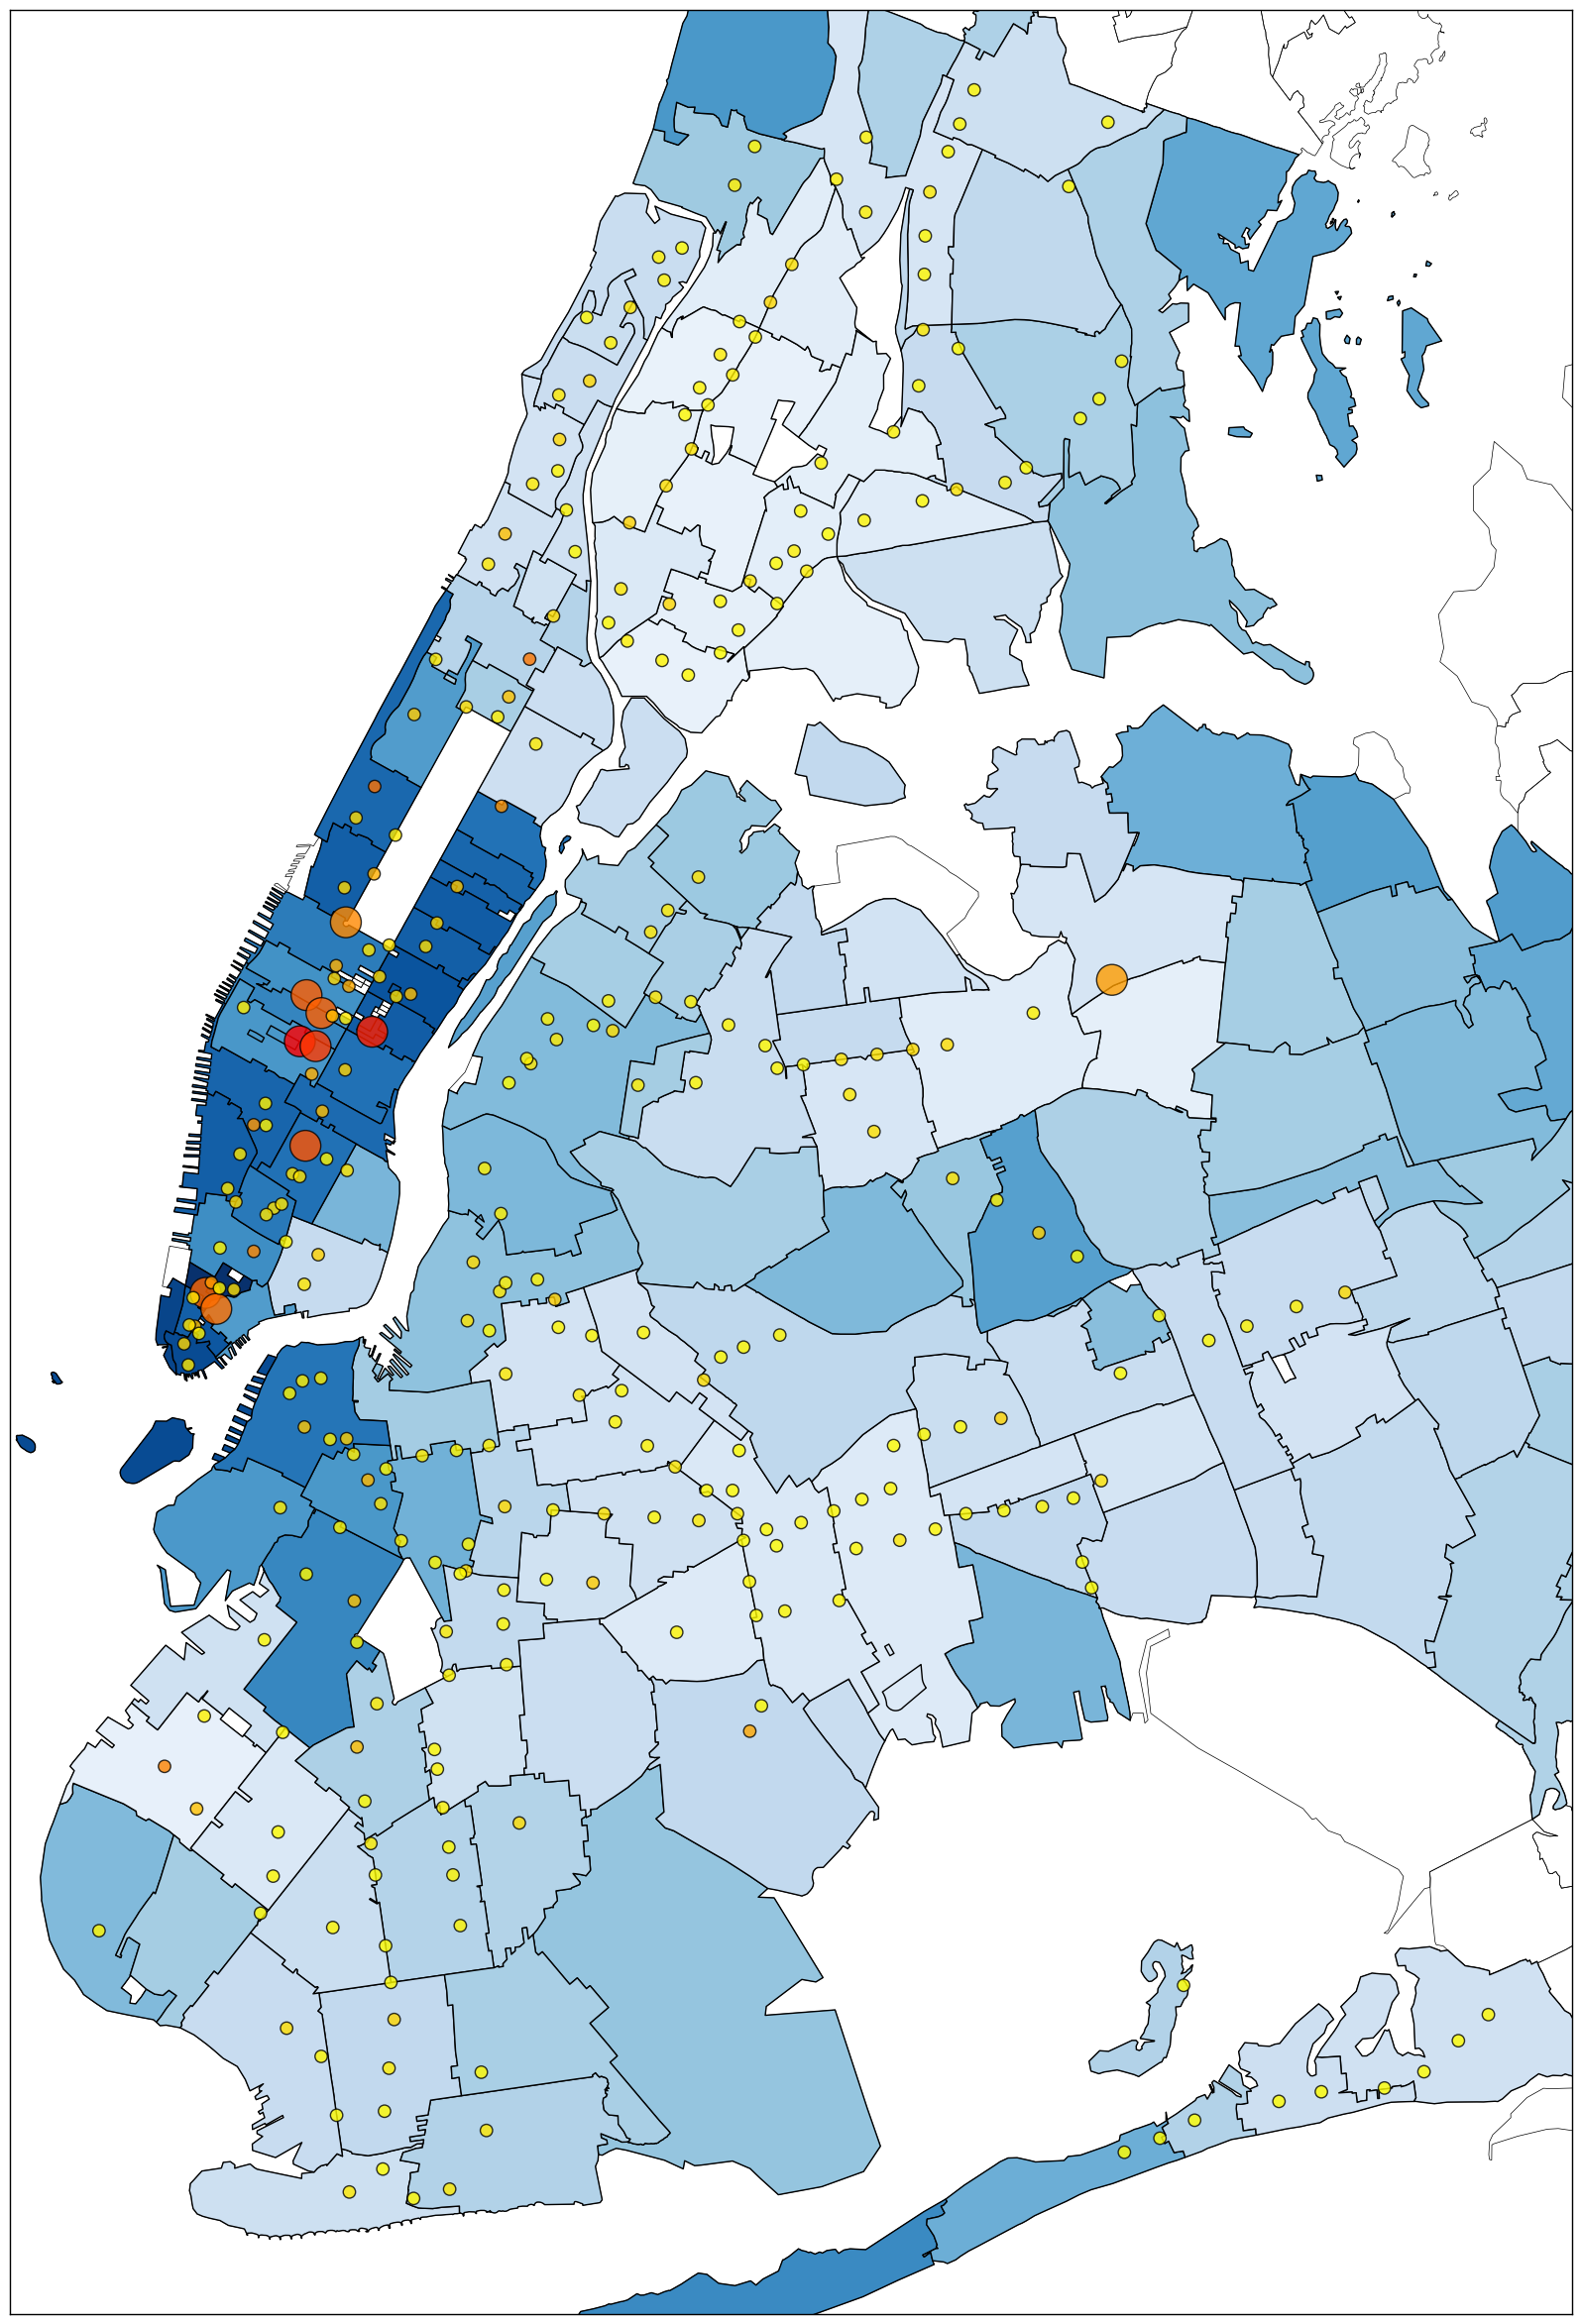

In [16]:
# Create Map Plot
llcrnrlat=40.55889
urcrnrlat=40.905133
llcrnrlon=-74.048538
urcrnrlon=-73.7389

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', resolution='h',
            llcrnrlat=40.55889, urcrnrlat=40.905133,
            llcrnrlon=-74.048538, urcrnrlon=-73.7389)
m.readshapefile('tl_2010_36_zcta510/tl_2010_36_zcta510', 'Zip_Codes')

m.fillcontinents(color='#ffffff',lake_color='aqua')

## Figure out required zip codes
# zip_data = np.array([[int(i['SHAPENUM']) for i in m.Zip_Codes_info],
#                      [int(i['ZCTA5CE10']) for i in m.Zip_Codes_info],
#                      [float(i['INTPTLAT10']) for i in m.Zip_Codes_info],
#                      [float(i['INTPTLON10']) for i in m.Zip_Codes_info]])
# df_zips = pd.DataFrame(zip_data.T, columns=['ShapeNum', 'ZipCode', 'Lat', 'Lon'])

# Zip codes with (llcrnrlat < lat < urcrnrlat) and (llcrnrlon < lon < urcrnrlon)
# mask = ((df_zips['Lat'] > llcrnrlat) &
#         (df_zips['Lat'] < urcrnrlat) & 
#         (df_zips['Lon'] > llcrnrlon) &
#         (df_zips['Lon'] < urcrnrlon))
# required_zips = df_zips[mask]['ZipCode'].drop_duplicates()


## Shade zip region if zip is in list of required zips
# facecolor_values = {1: '#eeeeff',
#                     2: '#ccccee',
#                     3: '#aaaadd',
#                     4: '#7777cc',
#                     5: '#4444bb',
#                     6: '#0000aa'}

# zip_colors = {}
# for zip_code in list(df_inc_bracket.index):
#     zip_colors[zip_code] = facecolor_values[df_inc_bracket['agi_stub'].loc[zip_code]]

patches   = []
patch_colors = []
cmap = cm.get_cmap('Blues')
for info, shape in zip(m.Zip_Codes_info, m.Zip_Codes):
    if int(info['ZCTA5CE10']) in list(df_income.index):
        patches.append( Polygon(np.array(shape), True) )
#         patch_colors.append(zip_colors[int(info['ZCTA5CE10'])])
        try:
            cur_zip = int(info['ZCTA5CE10'])
            cur_color_val = (df_income[cur_zip]-1.3)*255/3.2
            cur_color = rgb2hex(cmap(int(cur_color_val)))
            patch_colors.append(cur_color)
        except:
            print('ERROR!')
            patch_colors.append(rgb2hex(cmap(0)))
ax.add_collection(PatchCollection(patches, 
                                  facecolor=patch_colors, 
                                  edgecolor='k', linewidths=1., zorder=2))

## Add scatterplot for subway stations
x, y = m(df_comb['Lon'].values, df_comb['Lat'].values)
m.scatter(x, y, marker='o',
          c=df_comb['Traffic'],
          s=df_comb['Size'], 
          cmap='autumn_r', 
          zorder=3, alpha=0.8)

# Add labels for top X dots
# for i, txt in enumerate(zip(x, y, df_comb['Size'].values, df_comb['Name_Adj'].values)):
#     if txt[2] == top_size:
#         ax.text(txt[0]+400, txt[1], s=txt[3], size=8, backgroundcolor='white', alpha=0.5)

plt.show()

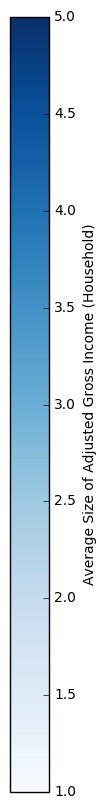

In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(0.5)

cmap = mpl.cm.get_cmap('Blues')
norm = mpl.colors.Normalize(vmin=1, vmax=5)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Average Size of Adjusted Gross Income (Household)')

fig.show()

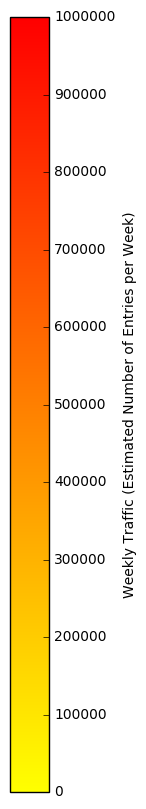

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(0.5)

cmap = mpl.cm.get_cmap('autumn_r')
norm = mpl.colors.Normalize(vmin=0, vmax=1000000)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Weekly Traffic (Estimated Number of Entries per Week)')
fig.show()

In [39]:
# Plot apple store locations

In [85]:
# Plot "Tech Titans"
# Adobe, Amazon, AngelList, Aol., Apple, Autodesk,
# Bloombert, Cisco, Comcast, Dell, Ebay, Facebook,
# GE, Google, HP, IBM, Intel, LinkedIn, Microsoft,
# Oracle, Panasonic, Pandora, PayPal, Pinterest,
# Samsung, SAP, Slack, Snapchat, Sony, Spotify, Square,
# Symantec, TimeWarner, Twitter, Yahoo
companies = [['Adobe', 40.7579565, -73.98465579999998],
 ['Amazon', 40.75227330000001, -73.99884150000003],
 ['AngelList', 40.7404572, -73.99019579999998],
 ['Aol.', 40.7306008, -73.99152170000002],
 ['Apple', 40.7408398, -74.00513819999998],
 ['Autodesk', 40.7409346, -73.99265550000001],
 ['Bloomberg', 40.762, 73.96800000000002],
 ['Cisco_1', 40.7617491, -73.9680045],
 ['Cisco_2', 40.7511838, -73.99213939999999],
 ['Dell', 40.7513308, -73.99252050000001],
 ['Ebay', 40.74033560000001, -73.99518590000002],
 ['Facebook', 40.7306008, -73.99152170000002],
 ['GE', 40.7571519, -73.9726033],
 ['Google', 40.741355, -74.00320290000002],
 ['HP', 40.7408746, -74.00600409999998],
 ['IBM', 40.7434963, -73.9855379],
 ['Intel', 40.7560149, -73.9838279],
 ['Linkedin', 40.7485626, -73.98574550000001],
 ['Microsoft', 40.7565357, -73.98988910000003],
 ['Oracle', 40.75175309999999, -73.97832840000001],
 ['Pinterest', 40.7524599, -73.98115810000002],
 ['SAP', 40.7525, -74.00104999999996],
 ['Snapchat', 40.7576077, -73.98736459999998]]

In [86]:
df_companies = pd.DataFrame(companies, columns=['Company', 'Lat', 'Lon'])
df_companies

,Company,Lat,Lon
0,Adobe,40.757956,-73.984656
1,Amazon,40.752273,-73.998842
2,AngelList,40.740457,-73.990196
3,Aol.,40.730601,-73.991522
4,Apple,40.740840,-74.005138
5,Autodesk,40.740935,-73.992656
6,Bloomberg,40.762000,73.968000
7,Cisco_1,40.761749,-73.968005
8,Cisco_2,40.751184,-73.992139
9,Dell,40.751331,-73.992521


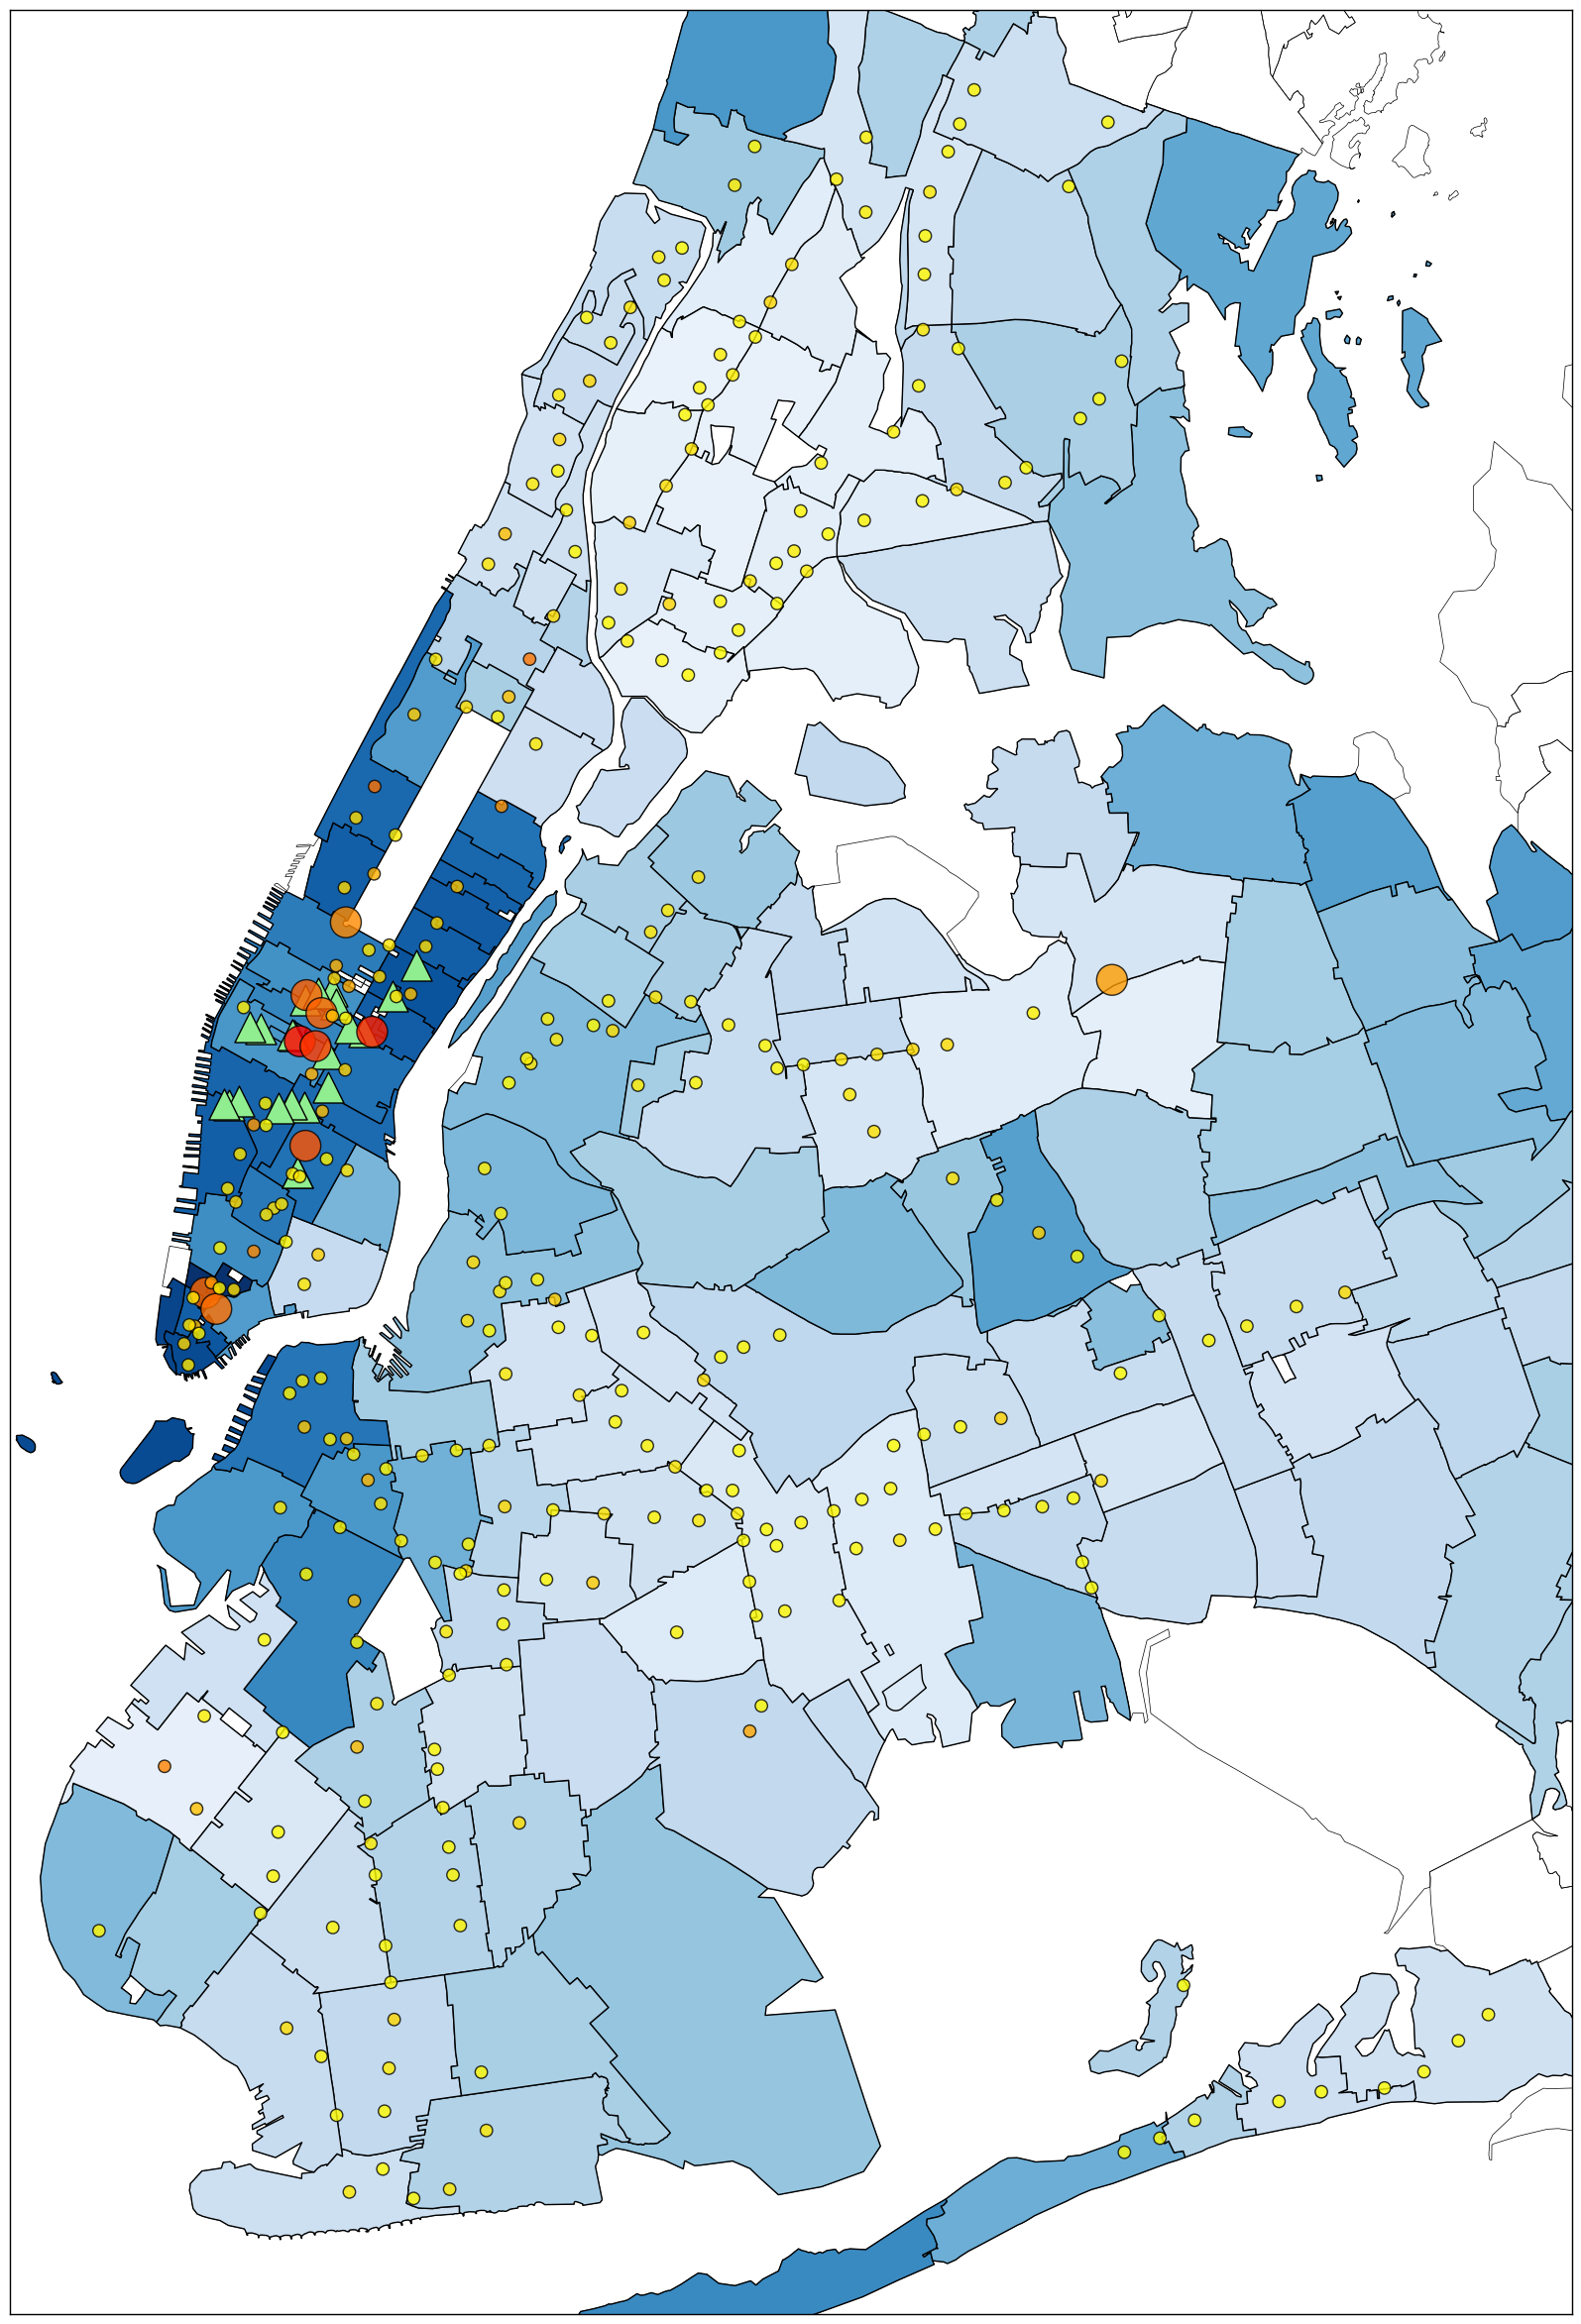

In [87]:
# Create Map Plot
llcrnrlat=40.55889
urcrnrlat=40.905133
llcrnrlon=-74.048538
urcrnrlon=-73.7389

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', resolution='h',
            llcrnrlat=40.55889, urcrnrlat=40.905133,
            llcrnrlon=-74.048538, urcrnrlon=-73.7389)
m.readshapefile('tl_2010_36_zcta510/tl_2010_36_zcta510', 'Zip_Codes')

m.fillcontinents(color='#ffffff',lake_color='aqua')

## Figure out required zip codes
# zip_data = np.array([[int(i['SHAPENUM']) for i in m.Zip_Codes_info],
#                      [int(i['ZCTA5CE10']) for i in m.Zip_Codes_info],
#                      [float(i['INTPTLAT10']) for i in m.Zip_Codes_info],
#                      [float(i['INTPTLON10']) for i in m.Zip_Codes_info]])
# df_zips = pd.DataFrame(zip_data.T, columns=['ShapeNum', 'ZipCode', 'Lat', 'Lon'])

# Zip codes with (llcrnrlat < lat < urcrnrlat) and (llcrnrlon < lon < urcrnrlon)
# mask = ((df_zips['Lat'] > llcrnrlat) &
#         (df_zips['Lat'] < urcrnrlat) & 
#         (df_zips['Lon'] > llcrnrlon) &
#         (df_zips['Lon'] < urcrnrlon))
# required_zips = df_zips[mask]['ZipCode'].drop_duplicates()


## Shade zip region if zip is in list of required zips
# facecolor_values = {1: '#eeeeff',
#                     2: '#ccccee',
#                     3: '#aaaadd',
#                     4: '#7777cc',
#                     5: '#4444bb',
#                     6: '#0000aa'}

# zip_colors = {}
# for zip_code in list(df_inc_bracket.index):
#     zip_colors[zip_code] = facecolor_values[df_inc_bracket['agi_stub'].loc[zip_code]]

patches   = []
patch_colors = []
cmap = cm.get_cmap('Blues')
for info, shape in zip(m.Zip_Codes_info, m.Zip_Codes):
    if int(info['ZCTA5CE10']) in list(df_income.index):
        patches.append( Polygon(np.array(shape), True) )
#         patch_colors.append(zip_colors[int(info['ZCTA5CE10'])])
        try:
            cur_zip = int(info['ZCTA5CE10'])
            cur_color_val = (df_income[cur_zip]-1.3)*255/3.2
            cur_color = rgb2hex(cmap(int(cur_color_val)))
            patch_colors.append(cur_color)
        except:
            print('ERROR!')
            patch_colors.append(rgb2hex(cmap(0)))
ax.add_collection(PatchCollection(patches, 
                                  facecolor=patch_colors, 
                                  edgecolor='k', linewidths=1., zorder=2))

## Add scatterplot for subway stations
# mask = (df_comb['Size'] == TOP_SIZE)
mask = (df_comb['Size'] > 0) # ALL VALUES
x, y = m(df_comb[mask]['Lon'].values, df_comb[mask]['Lat'].values)
m.scatter(x, y, marker='o',
          c=df_comb[mask]['Traffic'],
          s=df_comb[mask]['Size'], 
          cmap='autumn_r', 
          zorder=4, alpha=0.8)

x, y = m(df_companies['Lon'].values, df_companies['Lat'].values)
m.scatter(x, y, marker='^', c='lightgreen', zorder=3, s=500)

# Add labels for top X dots
for i, txt in enumerate(zip(x, y)):
    if txt[2] == top_size:
        ax.text(txt[0]+400, txt[1], s=txt[3], size=8, backgroundcolor='white', alpha=0.5)

plt.show()

In [88]:
## Plot Apple Stores
stores = [['45 Grand Central Terminal, New York, NY 10017',40.752726,    -73.977229],
['401 W 14th Street New York, NY 10014',   40.730610,  -73.935242],
['767 5th ave new york ny 10153'   ,40.7638    ,-73.9729],
['103 Prince St, New York, NY 10012'   ,40.7251148,-73.9989687],
['1981 Broadway New York, NY 10023'    ,40.7751    ,-73.9827],
[ '940 Madison Ave, New York, NY 10021'    ,40.773379, -73.9645457],
['185 Greenwich St, New York, NY 10007',   40.7133 ,-74.0116]]

df_apple = pd.DataFrame(stores, columns=['Address', 'Lat', 'Lon'])
df_apple

,Address,Lat,Lon
0,"45 Grand Central Terminal, New York, NY 10017",40.752726,-73.977229
1,"401 W 14th Street New York, NY 10014",40.730610,-73.935242
2,767 5th ave new york ny 10153,40.763800,-73.972900
3,"103 Prince St, New York, NY 10012",40.725115,-73.998969
4,"1981 Broadway New York, NY 10023",40.775100,-73.982700
5,"940 Madison Ave, New York, NY 10021",40.773379,-73.964546
6,"185 Greenwich St, New York, NY 10007",40.713300,-74.011600


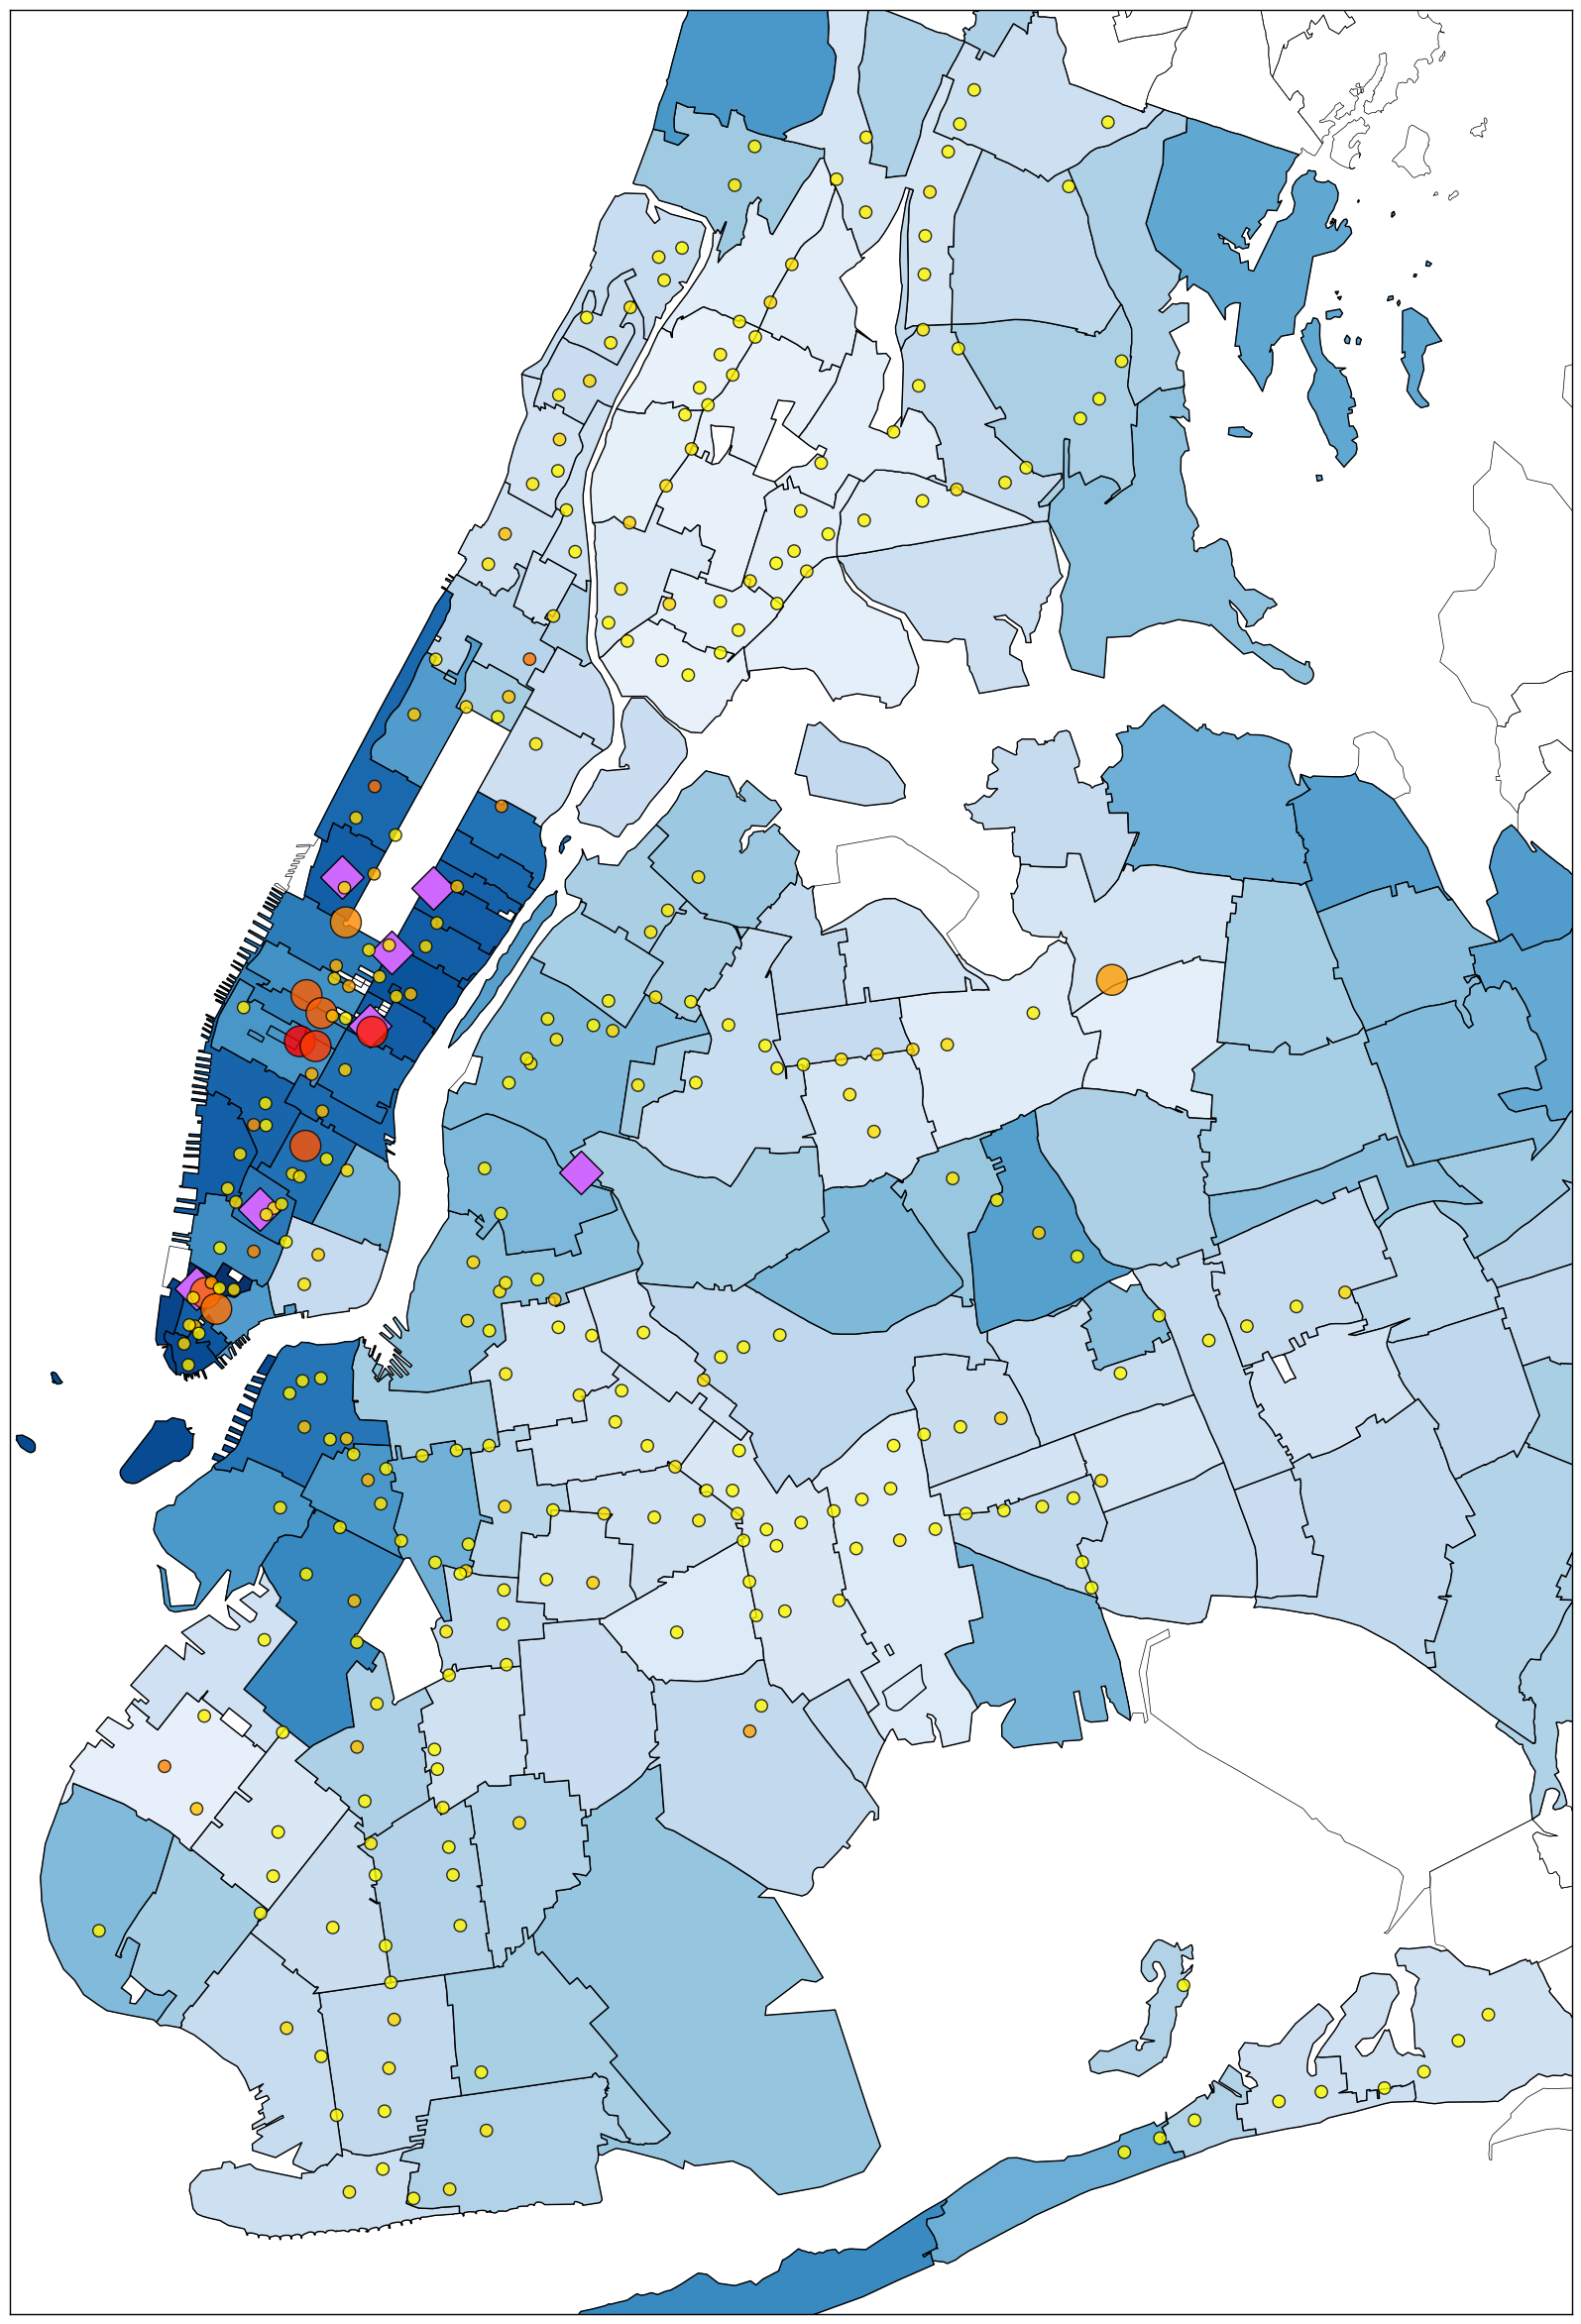

In [89]:
# Create Map Plot
llcrnrlat=40.55889
urcrnrlat=40.905133
llcrnrlon=-74.048538
urcrnrlon=-73.7389

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', resolution='h',
            llcrnrlat=40.55889, urcrnrlat=40.905133,
            llcrnrlon=-74.048538, urcrnrlon=-73.7389)
m.readshapefile('tl_2010_36_zcta510/tl_2010_36_zcta510', 'Zip_Codes')

m.fillcontinents(color='#ffffff',lake_color='aqua')

## Figure out required zip codes
# zip_data = np.array([[int(i['SHAPENUM']) for i in m.Zip_Codes_info],
#                      [int(i['ZCTA5CE10']) for i in m.Zip_Codes_info],
#                      [float(i['INTPTLAT10']) for i in m.Zip_Codes_info],
#                      [float(i['INTPTLON10']) for i in m.Zip_Codes_info]])
# df_zips = pd.DataFrame(zip_data.T, columns=['ShapeNum', 'ZipCode', 'Lat', 'Lon'])

# Zip codes with (llcrnrlat < lat < urcrnrlat) and (llcrnrlon < lon < urcrnrlon)
# mask = ((df_zips['Lat'] > llcrnrlat) &
#         (df_zips['Lat'] < urcrnrlat) & 
#         (df_zips['Lon'] > llcrnrlon) &
#         (df_zips['Lon'] < urcrnrlon))
# required_zips = df_zips[mask]['ZipCode'].drop_duplicates()


## Shade zip region if zip is in list of required zips
# facecolor_values = {1: '#eeeeff',
#                     2: '#ccccee',
#                     3: '#aaaadd',
#                     4: '#7777cc',
#                     5: '#4444bb',
#                     6: '#0000aa'}

# zip_colors = {}
# for zip_code in list(df_inc_bracket.index):
#     zip_colors[zip_code] = facecolor_values[df_inc_bracket['agi_stub'].loc[zip_code]]

patches   = []
patch_colors = []
cmap = cm.get_cmap('Blues')
for info, shape in zip(m.Zip_Codes_info, m.Zip_Codes):
    if int(info['ZCTA5CE10']) in list(df_income.index):
        patches.append( Polygon(np.array(shape), True) )
#         patch_colors.append(zip_colors[int(info['ZCTA5CE10'])])
        try:
            cur_zip = int(info['ZCTA5CE10'])
            cur_color_val = (df_income[cur_zip]-1.3)*255/3.2
            cur_color = rgb2hex(cmap(int(cur_color_val)))
            patch_colors.append(cur_color)
        except:
            print('ERROR!')
            patch_colors.append(rgb2hex(cmap(0)))
ax.add_collection(PatchCollection(patches, 
                                  facecolor=patch_colors, 
                                  edgecolor='k', linewidths=1., zorder=2))

## Add scatterplot for subway stations
# mask = (df_comb['Size'] == TOP_SIZE)
mask = (df_comb['Size'] > 0) # ALL VALUES
x, y = m(df_comb[mask]['Lon'].values, df_comb[mask]['Lat'].values)
m.scatter(x, y, marker='o',
          c=df_comb[mask]['Traffic'],
          s=df_comb[mask]['Size'], 
          cmap='autumn_r', 
          zorder=4, alpha=0.8)

x, y = m(df_apple['Lon'].values, df_apple['Lat'].values)
m.scatter(x, y, marker='D', c='#cf68ff', zorder=3, s=500)

## Add labels for top X dots
# for i, txt in enumerate(zip(x, y, df_comb['Size'].values, df_comb['Name_Adj'].values)):
#     if txt[2] == top_size:
#         ax.text(txt[0]+400, txt[1], s=txt[3], size=8, backgroundcolor='white', alpha=0.5)

plt.show()